<font size="6">Report</font>

I preformed a tumor segmentation on data from lung radiology scans.  The data was taken from the LUNG1 dataset which is publicly available from The Cancer Imaging Archive: https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics 

<font size="5">Data Preparation</font>

The first step was getting familiar with the data.  I have never worked with Dicom data before.  I used pyDicom to explore the data within a Juypter notebook and designed simple python functions to import the important information I needed, namely the CT scan slices of lungs (the loadScan function in function.py) and the contours of known manually identified tumors/nodes (the loadContour function in function.py).

Once I had the data, and after reading up on the approaches to segmenting lung growths from several different blogs I decided it would be a good idea to focus the images in on the areas of interest to help ease the job our neural net needed to do.  I created a function to mask out everything but the lung for a given CT scan (the maskLung function in function.py).  

The first step is to normalize the pixel values.  Some patients had their data taken with values between -1024 and 3074, while others had values between 0 and 4098. After looking into what those values meant, I chose to normalize them all to be values between 0 and 1 by subtracing -1024 if the minimum pixel was negative, and then dividing by 4098.  I wanted to allow scans that did not have maximum values to retain their pixel values relitive to other scans.  Then a k-mean algorithm was used to separate the pixels into two populations (soft tissue/bone vs lung/air).  The image was then passed through an erosion and dilation filter to remove smaller features, making lung boundaries easier to find.  Once that was done the different regions were separated and labeled, and the areas outside of the lung are masked our of the image.

The below image shows CT scans from three patients with and without lung masking. 

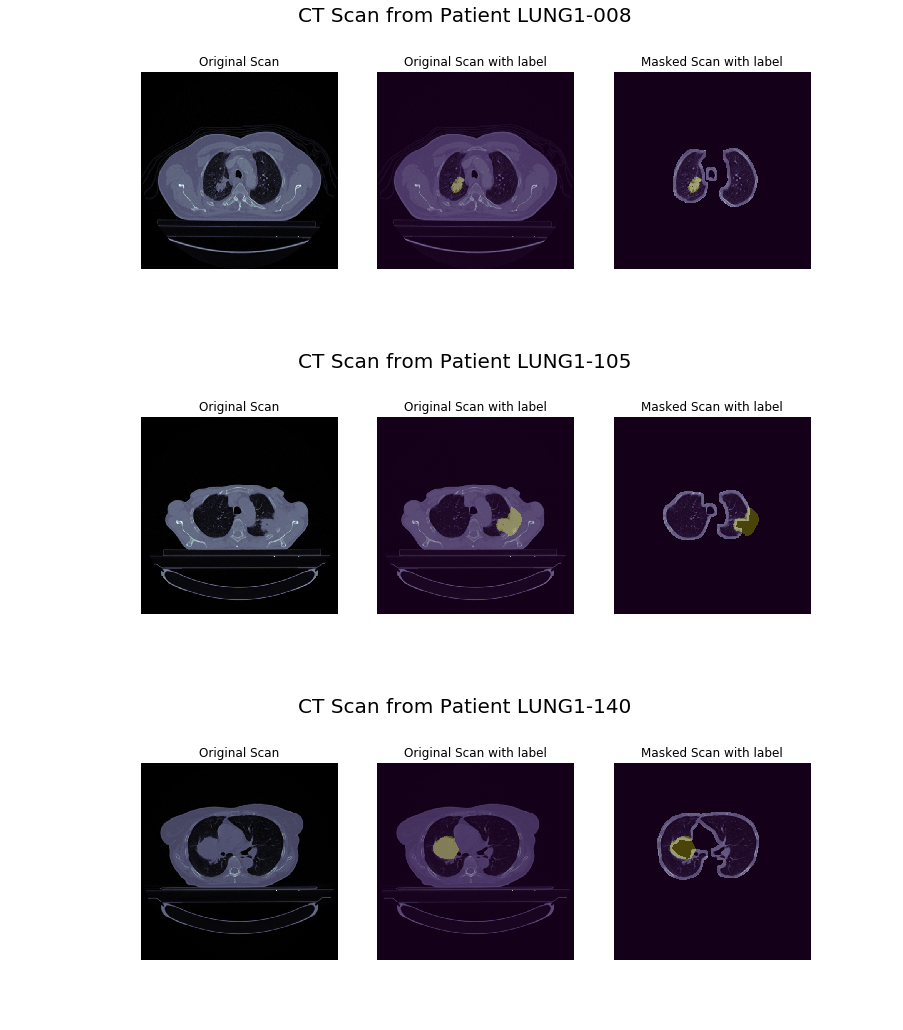

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img1 = mpimg.imread('docImages//P8Mask.png')
img2 = mpimg.imread('docImages//P105Mask.png')
img3 = mpimg.imread('docImages//P140Mask.png')

fig,ax = plt.subplots(3,1,figsize=[18,18])
ax[0].set_title("CT Scan from Patient LUNG1-008",fontsize=20)
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].set_title("CT Scan from Patient LUNG1-105",fontsize=20)
ax[1].imshow(img2)
ax[1].axis('off')
ax[2].set_title("CT Scan from Patient LUNG1-140",fontsize=20)
ax[2].imshow(img3)
ax[2].axis('off')

plt.show()

After masking out pixels outside of our ROI we matched our contours to the correct CT scan slices based on patient coordinate system z-values.  The was done by the function labelTumor in function.py.

The final step of preparing the data was to select what data we would pass on to our neural network. I created several different datasets for training.  Each dataset has its own random seed.  For all datasets The lungs were then zoomed in on, changing the 512-512 pixel images into 256-256 pixel images.  This was a rough measure to remove blank space from the images, speeding up training.  It could be done more carefully in the future however.  In about 5% of patients a part or all of the tumor region was cut from the image due to this.  Additionally, all images were saved as 3 layer color images by passing the slice before, and the slice after the given scan with it.  This was done to give the neural network more information to use to distiguish things like vains and the lung walls from tumors.

The below images show some examples of zoomed 3 layer color images.  Note how changes in color show rapidly changing structures while gray denotes and image that is consitant between layers. (These images were selected from amoung data3's test images and are all from different patients, and contain tumors.)

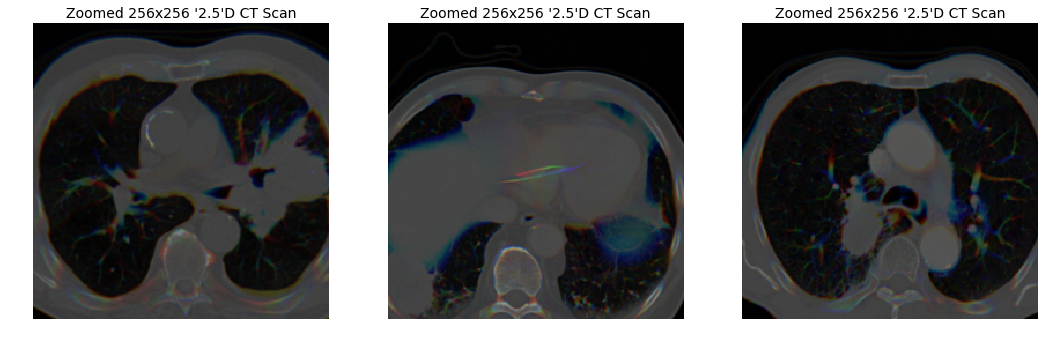

In [26]:
img1 = mpimg.imread('docImages//0.png')
img2 = mpimg.imread('docImages//38.png')
img3 = mpimg.imread('docImages//46.png')

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].set_title("Zoomed 256x256 '2.5'D CT Scan",fontsize=14)
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].set_title("Zoomed 256x256 '2.5'D CT Scan",fontsize=14)
ax[1].imshow(img2)
ax[1].axis('off')
ax[2].set_title("Zoomed 256x256 '2.5'D CT Scan",fontsize=14)
ax[2].imshow(img3)
ax[2].axis('off')

plt.show()

The first dataset (data1) and the third dataset (data3) were selected from patients LUNG1-001 through LUNG1-040.  CT scan slices from the middle 50% of identified tumors and their matching tumor masks were chosen.  That data was subsequently randomly split slice by slice between training and test data sets.  75% of the data went to the training set, while 25% went to the test data set.  Data3 did not have the RIO mask applied to it.  Data1 has 310 training images and masks, and 93 test images and masks.  Data3 has 306 training images and masks, and 97 test images.

The second dataset (data2) and the fourth dataset (data4) were created from patients LUNG1-101 to LUNG1-140.  CT scan slices were selected randomly from the middle 75% of the lung and their matching tumor masks in an atempt to cut out the non-lung portions of the CT scans.  The a random number of a random selection of slices were chosen such that there was a 1:1 ratio of those with and without nodules from each patient.  That data was subsequently randomly split slice by slice between training and test data sets.  75% of the data went to the training set, while 25% went to the test data set. Data4 did not have the RIO mask applied to it.  Data2 has 552 training images and masks and 182 test images and masks.  Data4 has 583 training images and masks and 185 test images.  

I created datasets with and without healthy CT scans because I was not sure if training the neural network on images that all contained tumors would make the network unable to identify images as clean of cancer.  Having both data sets allowed me to test networks trained on either data set against the test images from the other.  I created datasets with and without the RIO mask because after looking at several mask I noted it often cut out the tumors.  Many of the tumors within the LUNG1 dataset are either conected to, or part of the lung walls.  I was not sure if the benifits of a cleaner image to look at would outway the lost information, and wanted to test it.

I created a data pipeline once all of the steps had been tested and debugged which can be found in MakeData.inpynb. This pipeline loaded in data from a single patient at a time, processed that data, then saved it to image files in the appropriate file locations before moving on to the next patient.  This was done to simplify and standardize the procedure as well as reduce the memory required to process the data.  

<font size="5">Model Selection</font>

After experimentation and research I decided on the UNet deep learning framework from ‘U-Net: Convolutional Networks for Biomedical Image Segmentation’ by Olaf Ronneberger et.al.  My first thought was to create 3 dimensional pixel maps and masks from the stacks of CT scans, and run them through a 3 dimensional convolutional neural network, however after looking into the amount of processing power and memory that would require (and seeing that its results were not better than many 2d approaches), I decided on a two dimensional approach.  Based on discussions I have seen on past medical imaging Kaggle competitions, UNet is one of the best methods to segment and label medical images.  So I decided to utilize an existing implementation of UNet in Keras written by zhixuhao.  It can be cloned from Github at https://github.com/zhixuhao/unet.  Initially I found the network was always predicting no tumor nodes for my test and training data, which was obviously wrong.  I additionally modified this UNet by adding BatchNormalization layers after each convolution layer (except the final convolution) to add stability and assist it in training on my datasets.  This change seemed to fix the problem.

<font size="5">Results</font>

Loss and accuracy are calculated by UNet and Keras while I am training on the data.  The Loss function is calcualted using a binary crossentropy.

To decide if I should mask the RIO in our dataset I compared data1 and data3.  After training 20 epochs with 200 steps per epoch and a batch size of 2 on data1 I was able to reach an accuracy of 0.9848 and a loss of 0.2333.  For data3 after training we reached an accuracy of 0.9887 and a loss of 0.2634.  For both datasets the loss was still fairly steadly declining so I expect further training would continue to improve my results. Though the trained results on data1 did achieve a lower loss, when examening the actual predictions for the test data for both sets the data3 network seemed to do significantly better.  The data1 network frecuently (~50% of the time) predicts very large areas as cancerous when they are not, often even empty areas outside of the lungs.  The data1 network only very rairly miss the tumor completely though, less then 10% of the time.  The data3 network only predicted additional, much smaller cancerous regions ~10% of the time, and similarly to data1 predicted the tumor in the wrong location ~10% of the time.  I believe this implies it is better not to use a mask, and just use the raw data to preserve additional information, especially if i had allowed for more training.  The current maskData function could be reworked in the future so that I could more optimally choose the region of the image to zoom in on, and maybe even the size of the region.  If I were to implement that however I would want to be careful about having pixels in different images representing different real world areas.  (Note, percentages are obtained from only 30 images, so they have large uncertainty.)

To decide if I should use a dataset with healthy scans or not I compared data1 and data2. After the same training data1 went through, data2 reached an accuracy of 0.9937 and a loss of 0.2112.  However while both its accuracy and loss appear better than data1 this could be artificually inflated by predicting nothing in the 'easy' healthy scans.  When checking how it did on its own test images, it falls behind.  It missed an existing tumor <10% of the time, but similar to data1 predicted tumors that were not in the image frequently, about 30% of the time.  Though when data2 mispredicts tumors, they are small, not covering large portions of the image, which is far better than the behavior we saw from data1's precictions.  We need to check how both sets do at predicting the no-tumor result however.  So by applying data1's trained model to data2's test data we find that we get about a 10% success rate of identifying healthy CT scans, while data2's trained model had >70% accuracy.  Data2 actually did better or as well as data1 in every way we have checked.  This clearly implies I should use a training dataset that contains both healthy and un-healthy CT scans if I want my model to be able to predict a no-tumor result, and possibly even if I just want it to correctly predict tumors.  Of course, this makes sense... but I had hoped that having half a healthy lung in nearly every scan would train the network to identify healthy regions.  I also applied data3's trained model to data4's data, to see if it faired any better than data1 did ant identifying healthy lungs.  It had ~20% accuracy, so slightly better than data1, but it was still bad at identifying healthy lungs. 

It might be worth noting at this point that these test I decided to run were perhaps somewhat off assingment.  I became passionate about trying to find the best way to combine the tools I had already created for my data processing pipeline, and was unable to find answers by researching online.  I suspect that if fewer tumors were attached to, or part of the walls of the lungs in this dataset that the RIO masks may have yielded better results, but as is they were removing the pixel intensity information stored inside of larger tumors, so it makes sense that they would hurt the models accuracy.  I found a wide mix of people setting up their input datasets with and without including healthy tumors on various different forums while researching how to approch this problem, but no real discussion on the different approches.  This made me very curious and inspired me to attempt to check two different methods of selecting images I had read about online.  Perhaps either will work well with more training?  If time were not an issue, better more careful, and more conclusive tests could be designed to examine these issues.

After these tests It is clear that data4 is the dataset I should use and train on.  Unfortuently, as of completing these tests, I had not trained a model from scratch on data4, so instead to save some time I use the model trained on data3 as a starting point, and train from there. Since from this point forward I was not compairing to the other dataset's trained models, and just want obtain the best model possible, I still trained my model on data4 for 20 epochs.  

